In [18]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
from dataset import *
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader

In [50]:
df = pd.read_csv('../dataset/서인천IC-부평IC 평균속도.csv', encoding='CP949')

In [51]:
df.head()

,Unnamed: 0,집계일시,평균속도
0,0,2021050100,98.63
1,1,2021050101,100.53
2,2,2021050102,99.86
3,3,2021050103,99.34
4,4,2021050104,93.64


In [52]:
output_window = 12
input_window = 24
train_rate=0.7

ts_selected = df['평균속도']
train_size = int((len(ts_selected)-output_window) * train_rate)
valid_size = (len(ts_selected)-output_window)- train_size
train_data = np.array(ts_selected.iloc[:train_size]).reshape(-1,1)
valid_data = np.array(ts_selected.iloc[train_size:train_size+valid_size]).reshape(-1,1)


In [53]:
scaler = MinMaxScaler()
scaler.fit(train_data)
train_data_std = scaler.transform(train_data)
valid_data_std = scaler.transform(valid_data)   
# joblib.dump(scaler, os.path.join(log_dir, 'scaler.pkl'))

In [54]:
batch_size=64

#-- get dataloader
train = pd.DataFrame(train_data_std)
valid = pd.DataFrame(valid_data_std)

train_dataset = WindowDataset(train, input_window, output_window)
train_dataloader = DataLoader(train_dataset, batch_size)  

valid_dataset = WindowDataset(valid, input_window, output_window)
valid_dataloader = DataLoader(valid_dataset, batch_size)     

In [55]:
len(train_dataloader)

8

In [56]:
x,y,z = next(iter(train_dataloader))

In [57]:
x.shape

torch.Size([64, 24, 1])

In [58]:
y.shape

torch.Size([64, 12, 1])

In [59]:
z.shape

torch.Size([64, 12, 0])

In [60]:

df = pd.read_csv('../dataset/upbit_ohlcv_1700.csv')

#-- make datetime index
df['index'] = pd.to_datetime(df['index'], format="%Y-%m-%d %H:%M:%S")
df.set_index('index', inplace=True)

#-- train validation split 
ts_selected = df['open']
train_size = int((len(ts_selected)-output_window) * train_rate)
valid_size = (len(ts_selected)-output_window)- train_size
train_data = np.array(ts_selected.iloc[:train_size]).reshape(-1,1)
valid_data = np.array(ts_selected.iloc[train_size:train_size+valid_size]).reshape(-1,1)

#-- normalize data
scaler = MinMaxScaler()
scaler.fit(train_data)
train_data_std = scaler.transform(train_data)
valid_data_std = scaler.transform(valid_data)   
# joblib.dump(scaler, os.path.join(log_dir, 'scaler.pkl'))

#-- get dataloader
train = pd.DataFrame(train_data_std)
valid = pd.DataFrame(valid_data_std)

train_dataset = WindowDataset(train, input_window, output_window)
train_dataloader = DataLoader(train_dataset, batch_size)  

valid_dataset = WindowDataset(valid, input_window, output_window)
valid_dataloader = DataLoader(valid_dataset, batch_size)     





In [61]:
len(train_dataloader)

18

In [62]:
x,y,z = next(iter(train_dataloader))

In [63]:
x.shape

torch.Size([64, 24, 1])

In [64]:
y.shape

torch.Size([64, 12, 1])

In [48]:
z.shape

torch.Size([64, 168, 0])

In [65]:
df.shape

(1700, 6)

In [70]:
num_samples = (train_size - input_window - output_window) // 1 + 1
num_samples

1146

In [68]:
train_size

1181

In [69]:
valid_size

507

In [71]:
num_samples / 64

17.90625

# Inference

In [78]:
import pickle 
import joblib 
import matplotlib.pyplot as plt
history = joblib.load('../logs2/history.pkl')

In [79]:
train_loss = history['train'][0]['train_loss']
len(train_loss)

3000

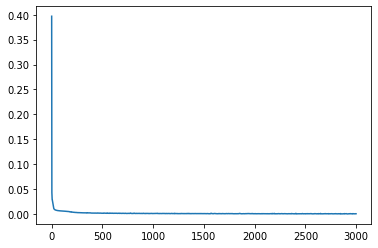

In [80]:
plt.plot(range(len(train_loss)), train_loss)

In [81]:
valid_loss = history['valid'][0]['valid_loss']
len(valid_loss)

3000

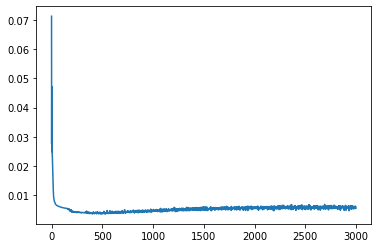

In [82]:
plt.plot(range(len(valid_loss)), valid_loss)

In [72]:
import joblib
import sys
sys.path.append('../')
from model import *


In [75]:
hidden_size = 32
output_window=12
input_window=24
target_len = output_window

In [84]:
df = pd.read_csv('../dataset/평균속도.csv', encoding='CP949')

scaler = joblib.load('../logs2/scaler.pkl')

pred = np.array(df.iloc[-(input_window + target_len):-target_len, :]['평균속도'])
pred = pred.reshape(-1,1)
pred_std = scaler.transform(pred)

model = seq2seq(1, hidden_size, output_window)
model.load_state_dict(torch.load('../logs2/model.pth'))



<All keys matched successfully>

In [85]:
device = 'cuda'
predict = model.predict(torch.tensor(pred_std).float())

predict = scaler.inverse_transform(predict.reshape(-1,1))
real = df['평균속도'].to_numpy()

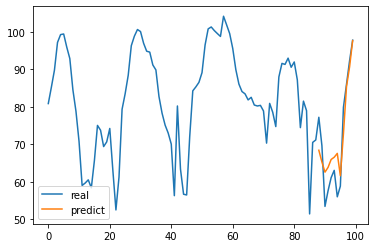

In [86]:
plt.plot(range(100), real[-100:], label='real')
plt.plot(range(100-target_len, 100), predict, label='predict')

plt.legend()
plt.show()

In [87]:
predict

array([[68.42324 ],
       [65.28504 ],
       [62.58643 ],
       [63.85358 ],
       [65.96118 ],
       [66.55998 ],
       [67.58321 ],
       [61.62506 ],
       [72.82864 ],
       [85.37093 ],
       [90.648766],
       [97.65045 ]], dtype=float32)

In [89]:
real[-12:]

array([77.21, 69.64, 53.45, 57.62, 61.12, 63.06, 56.01, 58.86, 79.86,
       86.01, 92.28, 97.76])

In [90]:
def MAPEval(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [92]:
MAPEval(predict, real[-12:].reshape(-1,1))

7.983714032652364